In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from keras.metrics import Recall
from itertools import product
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc, precision_recall_curve
import seaborn as sns

#### 1- Scaling 

In [2]:
df = pd.read_csv('ext_seq_ai4i.csv')

In [3]:
# We MinMax Normalize features
scaler = MinMaxScaler()
feature_cols = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Temperature difference [k]', 'Power [W]', 'Strain [minNm]']
df[feature_cols] = scaler.fit_transform(df[feature_cols])

# Prepare sequences  for time series representation by 'Product ID'
grouped = df.groupby('Product ID')
max_sequence_length = 10  # This is be based on the maximum sequence length observed

X = []
y = []

In [4]:
# Below we ensure matching dimensionality to proceed with training after sequencing
for _, group in grouped:
    sequence = group[feature_cols].values
    if len(sequence) > max_sequence_length:
        sequence = sequence[:max_sequence_length]
    X.append(sequence)
    y.append(group[['TWF', 'HDF', 'PWF', 'OSF', 'RNF']].values[-1])

X_padded = pad_sequences(X, maxlen=max_sequence_length, dtype='float32', padding='post', truncating='post', value=0.0)
y = np.array(y)

print(f"Shape of X_padded: {X_padded.shape}")
print(f"Shape of y: {y.shape}")



Shape of X_padded: (10000, 10, 8)
Shape of y: (10000, 5)


#### 2- Model Training and Testing

In [16]:


def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):  
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()



Processing failure type: TWF
After SMOTE, class distribution for TWF: [9954 9954]
Epoch 1/10
498/498 [==============================] - 8s 10ms/step - loss: 0.2082 - recall_9: 0.9816 - val_loss: 0.2136 - val_recall_9: 1.0000
Epoch 2/10
498/498 [==============================] - 5s 10ms/step - loss: 0.1584 - recall_9: 0.9891 - val_loss: 0.1457 - val_recall_9: 0.9944
Epoch 3/10
498/498 [==============================] - 5s 9ms/step - loss: 0.1528 - recall_9: 0.9912 - val_loss: 0.2084 - val_recall_9: 1.0000
Epoch 4/10
498/498 [==============================] - 5s 10ms/step - loss: 0.1485 - recall_9: 0.9915 - val_loss: 0.1302 - val_recall_9: 0.9842
Epoch 5/10
498/498 [==============================] - 4s 9ms/step - loss: 0.1390 - recall_9: 0.9941 - val_loss: 0.1266 - val_recall_9: 1.0000
Epoch 6/10
498/498 [==============================] - 5s 9ms/step - loss: 0.1358 - recall_9: 0.9929 - val_loss: 0.2166 - val_recall_9: 1.0000
Epoch 7/10
498/498 [==============================] - 4s 9ms/st

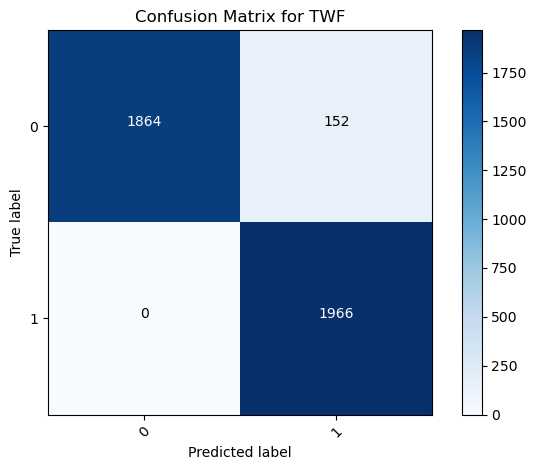

In [9]:
# Process TWF
failure_type = 'TWF'
print(f"Processing failure type: {failure_type}")

smote = SMOTE()
X_res, y_res = smote.fit_resample(X_padded.reshape(X_padded.shape[0], -1), y[:, 0])
X_res = X_res.reshape(-1, max_sequence_length, len(feature_cols))

print(f"After SMOTE, class distribution for {failure_type}: {np.bincount(y_res)}")

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

model = Sequential()
model.add(LSTM(50, input_shape=(max_sequence_length, len(feature_cols)), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Recall()])
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

models = {}
models[failure_type] = model

y_pred = (model.predict(X_test) > 0.5).astype(int)
loss, recall = model.evaluate(X_test, y_test)
print(f"Recall for {failure_type}: {recall:.2f}")
cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix for {failure_type}:\n{cm}")

plt.figure()
plot_confusion_matrix(cm, classes=[0, 1], title=f'Confusion Matrix for {failure_type}')
plt.show()

Processing failure type: HDF
After SMOTE, class distribution for HDF: [9885 9885]
Epoch 1/10
495/495 [==============================] - 9s 11ms/step - loss: 0.1197 - recall_10: 0.9903 - val_loss: 0.0620 - val_recall_10: 0.9903
Epoch 2/10
495/495 [==============================] - 5s 9ms/step - loss: 0.0666 - recall_10: 0.9946 - val_loss: 0.0506 - val_recall_10: 1.0000
Epoch 3/10
495/495 [==============================] - 5s 9ms/step - loss: 0.0531 - recall_10: 0.9952 - val_loss: 0.0312 - val_recall_10: 1.0000
Epoch 4/10
495/495 [==============================] - 5s 10ms/step - loss: 0.0322 - recall_10: 0.9979 - val_loss: 0.0308 - val_recall_10: 0.9980
Epoch 5/10
495/495 [==============================] - 5s 9ms/step - loss: 0.0267 - recall_10: 0.9981 - val_loss: 0.0150 - val_recall_10: 1.0000
Epoch 6/10
495/495 [==============================] - 4s 9ms/step - loss: 0.0310 - recall_10: 0.9972 - val_loss: 0.0236 - val_recall_10: 1.0000
Epoch 7/10
495/495 [==============================] 

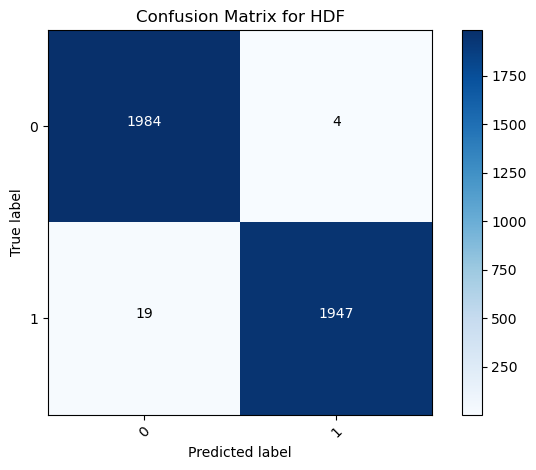

In [10]:
# Process HDF
failure_type = 'HDF'
print(f"Processing failure type: {failure_type}")

smote = SMOTE()
X_res, y_res = smote.fit_resample(X_padded.reshape(X_padded.shape[0], -1), y[:, 1])
X_res = X_res.reshape(-1, max_sequence_length, len(feature_cols))

print(f"After SMOTE, class distribution for {failure_type}: {np.bincount(y_res)}")

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

model = Sequential()
model.add(LSTM(50, input_shape=(max_sequence_length, len(feature_cols)), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Recall()])
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

models[failure_type] = model

y_pred = (model.predict(X_test) > 0.5).astype(int)
loss, recall = model.evaluate(X_test, y_test)
print(f"Recall for {failure_type}: {recall:.2f}")
f1 = f1_score(y_test, y_pred)
print(f"F1 Score for {failure_type}: {f1:.2f}")
cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix for {failure_type}:\n{cm}")

plt.figure()
plot_confusion_matrix(cm, classes=[0, 1], title=f'Confusion Matrix for {failure_type}')
plt.show()


Processing failure type: PWF
After SMOTE, class distribution for PWF: [9905 9905]
Epoch 1/10
496/496 [==============================] - 8s 10ms/step - loss: 0.1398 - recall_11: 0.9695 - val_loss: 0.0303 - val_recall_11: 0.9970
Epoch 2/10
496/496 [==============================] - 4s 9ms/step - loss: 0.0416 - recall_11: 0.9936 - val_loss: 0.0330 - val_recall_11: 0.9980
Epoch 3/10
496/496 [==============================] - 4s 8ms/step - loss: 0.0407 - recall_11: 0.9942 - val_loss: 0.0387 - val_recall_11: 1.0000
Epoch 4/10
496/496 [==============================] - 4s 9ms/step - loss: 0.0400 - recall_11: 0.9956 - val_loss: 0.0274 - val_recall_11: 0.9965
Epoch 5/10
496/496 [==============================] - 4s 9ms/step - loss: 0.0310 - recall_11: 0.9968 - val_loss: 0.0320 - val_recall_11: 0.9959
Epoch 6/10
496/496 [==============================] - 5s 10ms/step - loss: 0.0345 - recall_11: 0.9952 - val_loss: 0.0225 - val_recall_11: 0.9970
Epoch 7/10
496/496 [==============================] 

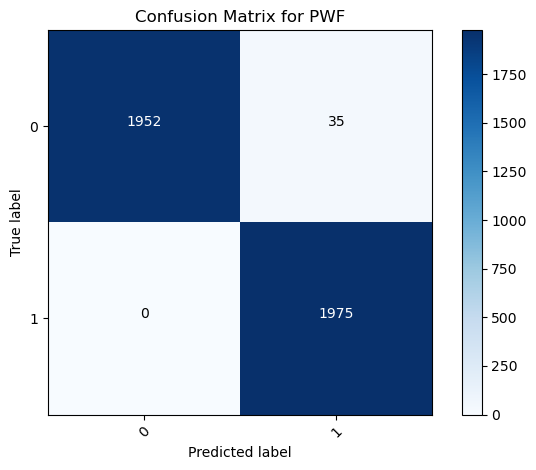

In [11]:
# Process PWF
failure_type = 'PWF'
print(f"Processing failure type: {failure_type}")

smote = SMOTE()
X_res, y_res = smote.fit_resample(X_padded.reshape(X_padded.shape[0], -1), y[:, 2])
X_res = X_res.reshape(-1, max_sequence_length, len(feature_cols))

print(f"After SMOTE, class distribution for {failure_type}: {np.bincount(y_res)}")

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

model = Sequential()
model.add(LSTM(50, input_shape=(max_sequence_length, len(feature_cols)), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Recall()])
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

models[failure_type] = model

y_pred = (model.predict(X_test) > 0.5).astype(int)
loss, recall = model.evaluate(X_test, y_test)
print(f"Recall for {failure_type}: {recall:.2f}")
f1 = f1_score(y_test, y_pred)
print(f"F1 Score for {failure_type}: {f1:.2f}")
cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix for {failure_type}:\n{cm}")

plt.figure()
plot_confusion_matrix(cm, classes=[0, 1], title=f'Confusion Matrix for {failure_type}')
plt.show()


Processing failure type: OSF
After SMOTE, class distribution for OSF: [9902 9902]
Epoch 1/10
496/496 [==============================] - 8s 11ms/step - loss: 0.0835 - recall_12: 0.9913 - val_loss: 0.0269 - val_recall_12: 1.0000
Epoch 2/10
496/496 [==============================] - 4s 8ms/step - loss: 0.0395 - recall_12: 0.9964 - val_loss: 0.0217 - val_recall_12: 0.9980
Epoch 3/10
496/496 [==============================] - 4s 9ms/step - loss: 0.0362 - recall_12: 0.9972 - val_loss: 0.0351 - val_recall_12: 1.0000
Epoch 4/10
496/496 [==============================] - 4s 8ms/step - loss: 0.0295 - recall_12: 0.9972 - val_loss: 0.0194 - val_recall_12: 1.0000
Epoch 5/10
496/496 [==============================] - 4s 8ms/step - loss: 0.0303 - recall_12: 0.9984 - val_loss: 0.1732 - val_recall_12: 1.0000
Epoch 6/10
496/496 [==============================] - 4s 9ms/step - loss: 0.0295 - recall_12: 0.9987 - val_loss: 0.0636 - val_recall_12: 1.0000
Epoch 7/10
496/496 [==============================] -

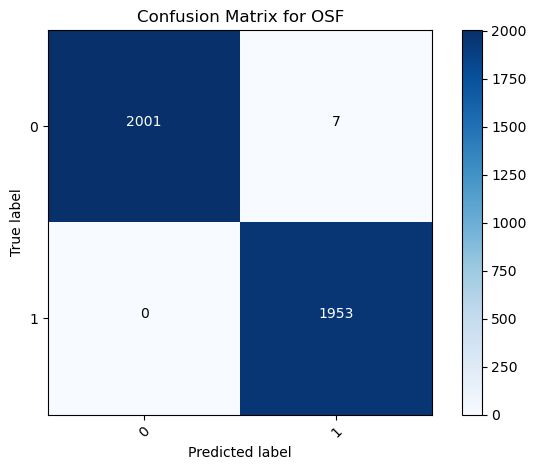

In [12]:
# Process OSF
failure_type = 'OSF'
print(f"Processing failure type: {failure_type}")

smote = SMOTE()
X_res, y_res = smote.fit_resample(X_padded.reshape(X_padded.shape[0], -1), y[:, 3])
X_res = X_res.reshape(-1, max_sequence_length, len(feature_cols))

print(f"After SMOTE, class distribution for {failure_type}: {np.bincount(y_res)}")

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

model = Sequential()
model.add(LSTM(50, input_shape=(max_sequence_length, len(feature_cols)), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Recall()])
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

models[failure_type] = model

y_pred = (model.predict(X_test) > 0.5).astype(int)
loss, recall = model.evaluate(X_test, y_test)
print(f"Recall for {failure_type}: {recall:.2f}")
f1 = f1_score(y_test, y_pred)
print(f"F1 Score for {failure_type}: {f1:.2f}")
cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix for {failure_type}:\n{cm}")

plt.figure()
plot_confusion_matrix(cm, classes=[0, 1], title=f'Confusion Matrix for {failure_type}')
plt.show()


Processing failure type: RNF
After SMOTE, class distribution for RNF: [9981 9981]
Epoch 1/10
500/500 [==============================] - 9s 11ms/step - loss: 0.5306 - recall_13: 0.8463 - val_loss: 0.4177 - val_recall_13: 0.9339
Epoch 2/10
500/500 [==============================] - 5s 10ms/step - loss: 0.3653 - recall_13: 0.9306 - val_loss: 0.3078 - val_recall_13: 0.9639
Epoch 3/10
500/500 [==============================] - 4s 9ms/step - loss: 0.2867 - recall_13: 0.9593 - val_loss: 0.2740 - val_recall_13: 0.9604
Epoch 4/10
500/500 [==============================] - 4s 9ms/step - loss: 0.2413 - recall_13: 0.9676 - val_loss: 0.2353 - val_recall_13: 0.9975
Epoch 5/10
500/500 [==============================] - 5s 9ms/step - loss: 0.2098 - recall_13: 0.9719 - val_loss: 0.1885 - val_recall_13: 0.9825
Epoch 6/10
500/500 [==============================] - 4s 9ms/step - loss: 0.1903 - recall_13: 0.9762 - val_loss: 0.1935 - val_recall_13: 1.0000
Epoch 7/10
500/500 [==============================] 

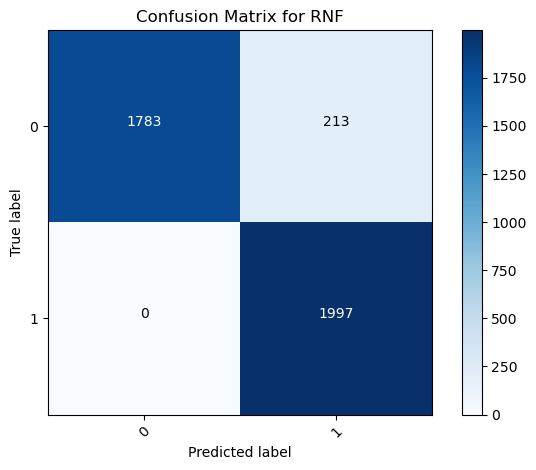

In [13]:
# Process RNF
failure_type = 'RNF'
print(f"Processing failure type: {failure_type}")

smote = SMOTE()
X_res, y_res = smote.fit_resample(X_padded.reshape(X_padded.shape[0], -1), y[:, 4])
X_res = X_res.reshape(-1, max_sequence_length, len(feature_cols))

print(f"After SMOTE, class distribution for {failure_type}: {np.bincount(y_res)}")

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

model = Sequential()
model.add(LSTM(50, input_shape=(max_sequence_length, len(feature_cols)), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Recall()])
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

models[failure_type] = model

y_pred = (model.predict(X_test) > 0.5).astype(int)
loss, recall = model.evaluate(X_test, y_test)
print(f"Recall for {failure_type}: {recall:.2f}")
f1 = f1_score(y_test, y_pred)
print(f"F1 Score for {failure_type}: {f1:.2f}")
cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix for {failure_type}:\n{cm}")

plt.figure()
plot_confusion_matrix(cm, classes=[0, 1], title=f'Confusion Matrix for {failure_type}')
plt.show()


#### Testing on sampled dataset

In [14]:
# Let us sample 20000 unseen data points to preprocess and test

new_df = df.sample(n=20000, replace=False, random_state=42) 

target_columns = ['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
new_df = new_df.drop(columns=target_columns)


print(new_df.head())

         UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
119737  5931     L53110    L             0.543478                 0.567901   
72272   2081     L49260    L             0.434783                 0.432099   
158154  8670     M23529    M             0.239130                 0.382716   
65426   4310     M19169    M             0.652174                 0.518519   
30074   5714     L52893    L             0.750000                 0.765432   

        Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  \
119737                0.183353     0.656593         0.197628   
72272                 0.647264     0.159341         0.818182   
158154                0.176368     0.666209         0.600791   
65426                 0.193830     0.490385         0.106719   
30074                 0.249127     0.469780         0.616601   

        Temperature difference [k]  Power [W]  Strain [minNm]  
119737                    0.533333   0.736472        0.156392  
72272             

In [15]:
# Below we will test for each failure type on the unseen data points
new_features = new_df[feature_cols] 

# Normalize the features using the MinMax scaler
new_features = scaler.transform(new_features)

# Preprocess sequences and pad as done above
grouped = new_df.groupby('Product ID')
X_new = []

for _, group in grouped:
    sequence = group[feature_cols].values
    if len(sequence) > max_sequence_length:
        sequence = sequence[:max_sequence_length] 
    X_new.append(sequence)

X_new_padded = pad_sequences(X_new, maxlen=max_sequence_length, dtype='float32', padding='post', truncating='post', value=0.0)


failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
predictions = {}

# Test our LSTM on the new chosen test datapoints from the augmented dataset
for failure_type in failure_types:
    model = models[failure_type]  
    predictions[failure_type] = model.predict(X_new_padded)

for failure_type, prediction in predictions.items():
    print(f"Predictions for {failure_type}:")
    print(prediction)  

271/271 [==============================] - 1s 3ms/step
Predictions for TWF:
[[1.5589027e-05]
 [1.5424157e-05]
 [1.7070482e-05]
 ...
 [1.7390785e-05]
 [1.7149865e-05]
 [1.7000753e-05]]
Predictions for HDF:
[[8.2339211e-06]
 [8.3800160e-06]
 [8.2599136e-06]
 ...
 [1.3458316e-03]
 [8.4865002e-05]
 [8.2539666e-01]]
Predictions for PWF:
[[1.0914646e-05]
 [1.0553428e-05]
 [1.0879615e-05]
 ...
 [1.1457059e-05]
 [1.1486433e-05]
 [1.0861472e-05]]
Predictions for OSF:
[[1.0496437e-05]
 [1.0245344e-05]
 [1.0868218e-05]
 ...
 [1.0929436e-05]
 [1.0897465e-05]
 [1.0898151e-05]]
Predictions for RNF:
[[3.3667646e-05]
 [4.8331451e-05]
 [6.2848492e-05]
 ...
 [3.5533169e-05]
 [3.9278664e-05]
 [4.3752974e-05]]
